In [1]:
from m_mapper import StyleCLIPMapper
from torchvision import transforms
from PIL import Image
import torch
from models.facial_recognition.model_irse import Backbone
from matplotlib import pyplot as plt
import torchvision
import numpy as np
import pickle
import insightface
import cv2
from tqdm import tqdm
import os

c:\Users\savel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\savel\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Инициализируем модели
Маппер с генератором изображений и ArcFace для распознавания 

In [2]:
maper = StyleCLIPMapper("./exp_12/checkpoints/iteration_30000.pt")
handler = insightface.model_zoo.get_model('w600k_r50.onnx')
handler.prepare(ctx_id=0)
pass

Loading from checkpoint: ./exp_12/checkpoints/iteration_30000.pt


c:\ML_stuff\BHACK_2\test_solution\m_mapper.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location='cuda:0')
c:\ML_stuff\BHACK_2\test_solut

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


### Загружаем словарь эмбеддингов LFW, полученных с помощью ArcFace

In [3]:
with open('emb_data.pkl', 'rb') as f:
    embed_dict = pickle.load(f)

### Расчитываем дистанции между парами изображений одинаковых/разных людей и парами изображение + изображение сгенерированное по его эмбеддингу

In [12]:
# одинаковые
def eq_dist(embed_dict):
    all_dist = []
    for person in embed_dict.keys():
        if(len(all_dist) > 20000):
            break
        emb = []
        for img in embed_dict[person].keys():
            emb.append(embed_dict[person][img])
        for i in range(len(emb)):
            for j in range(i + 1, len(emb)):
                source = emb[i]
                target = emb[j]
                num_dist = (np.sum(np.multiply(target, source))) / (np.sqrt(np.sum(np.multiply(target, target))) * np.sqrt(np.sum(np.multiply(source, source))))
                all_dist.append(num_dist)
    return all_dist

In [13]:
# разные
def neq_dist(embed_dict):
    all_dist = []
    for person in embed_dict.keys():
        if(len(all_dist) > 20000):
            break
        emb = embed_dict[person][list(embed_dict[person].keys())[0]]
        for p in embed_dict.keys():
            if (p != person):
                source = emb
                target = embed_dict[p][list(embed_dict[p].keys())[0]]
                num_dist = (np.sum(np.multiply(target, source))) / (np.sqrt(np.sum(np.multiply(target, target))) * np.sqrt(np.sum(np.multiply(source, source))))
                all_dist.append(num_dist)
    return all_dist

In [6]:
# сгенерированные
def gen_dist(embed_dict):
    all_dist = []
    for person in tqdm(embed_dict.keys()):
        os.mkdir("lfw_gen/" + person)
        for img in  embed_dict[person].keys():
            emb = embed_dict[person][img]
            emb = torch.Tensor(emb).to(torch.device("cuda:0"))
            gen_image = maper(emb)
            torchvision.utils.save_image(gen_image.cpu(), "lfw_gen/" + person + "/" + img[:-4] + "_gen.jpg",
                                     normalize=True)
            gen_img = cv2.imread("lfw_gen/" + person + "/" + img[:-4] + "_gen.jpg")
            gen_emb = handler.get_feat(gen_img)[0]
            emb = emb.cpu().detach().numpy()
            num_dist = (np.sum(np.multiply(emb, gen_emb))) / (np.sqrt(np.sum(np.multiply(emb, emb))) * np.sqrt(np.sum(np.multiply(gen_emb, gen_emb))))
            all_dist.append(num_dist)
    return all_dist

In [14]:
eq_d = eq_dist(embed_dict)
neq_d = neq_dist(embed_dict)

In [8]:
gen_d = gen_dist(embed_dict)

100%|██████████| 5748/5748 [36:16<00:00,  2.64it/s]   


In [11]:
len(gen_d)

13229

### Считаем attack success rate
Количество сгенерированных изображений, прошедших порог / количество всех сгенерированных изображений

In [15]:
t = 0
f = 0
for d in gen_d:
    if (d >= 0.2):
        t += 1
    else:
        f += 1
print(f"Attack success rate (accuracy): {t / (t + f)}")

Attack success rate (accuracy): 0.9758107188751984


### Строим распределение

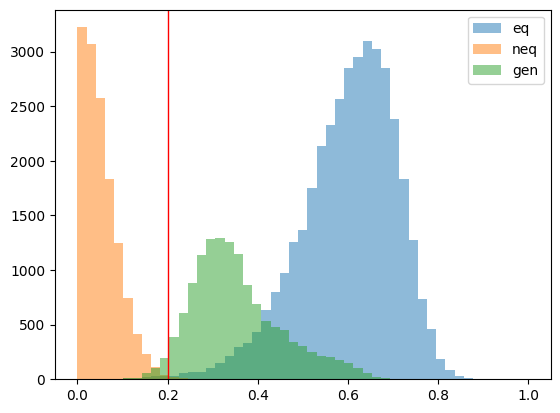

In [16]:
bins = np.linspace(0, 1, 50)

plt.hist(eq_d, bins, alpha=0.5, label='eq')
plt.hist(neq_d, bins, alpha=0.5, label='neq')
plt.hist(gen_d, bins, alpha=0.5, label='gen')
plt.axvline(0.2, color='r', linewidth=1)
plt.legend(loc='upper right')
plt.show()

### Генерируем изображения для тестового датасета эмбеддингов

In [17]:
with open('embedding_v3.pickle', 'rb') as f:
    embed_dict_test = pickle.load(f)

In [24]:
def gen_dist_test(embed_dict_test):
    all_dist = []
    for img in  embed_dict_test.keys():
        emb = embed_dict_test[img]["embedding"]
        emb = torch.Tensor(emb).to(torch.device("cuda:0"))
        gen_image = maper(emb)
        torchvision.utils.save_image(gen_image.cpu(), "test_gen/" + img,
                                     normalize=True)
        gen_img = cv2.imread("test_gen/" + img)
        gen_emb = handler.get_feat(gen_img)[0]
        
        emb = emb.cpu().detach().numpy()
        
        num_dist = (np.sum(np.multiply(emb, gen_emb))) / (np.sqrt(np.sum(np.multiply(emb, emb))) * np.sqrt(np.sum(np.multiply(gen_emb, gen_emb))))
        all_dist.append(num_dist)
    return all_dist

In [25]:
gen_d_test = gen_dist_test(embed_dict_test)

### Считаем attack success rate

In [26]:
t = 0
f = 0
for d in gen_d_test:
    if (d >= 0.2):
        t += 1
    else:
        f += 1
print(f"Attack success rate (accuracy): {t / (t + f)}")

Attack success rate (accuracy): 1.0
